# Chapitre 4 - La préparation des données et les premières statistiques (2ème partie)

Avant de rentrer dans le détail de ce chapitre, nous allons commencer par charger les packages et importer les données nécessaies aux traitements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Données AirBnB

In [2]:
# Import d'un extrait
listing=pd.read_csv("../data/listing_extrait.csv", index_col=0)
calendar=pd.read_csv("../data/calendar_extrait.csv",index_col=0)
# Import du fichier complet
#listing=pd.read_csv("https://www.stat4decision.com/listing.csv.gz", index_col=0)
#calendar=pd.read_csv("https://www.stat4decision.com/calendar.csv.gz", index_col=0)

Données sur les employés de la ville de Boston

In [3]:
boston=pd.read_csv("../data/employee-earnings-report-2017.csv")

## 4.3 Décrire et transformer des colonnes
### 4.3.1 D écrire la structure de vos données
Quel que soit le type de structure que vous utilisez ; les arrays, les Series ou
les DataFrame, on utilise généralement une propriété de ces objets : la propriété
    .shape. Celle-ci renvoie toujours un tuple, qui aura autant d’éléments que de dimensions
dans vos données.

In [4]:
calendar.shape

(10000, 4)

Cette information est importante mais reste peu détaillée. Lorsqu’on travaille sur
un DataFrame, on va chercher à avoir beaucoup plus de détails. Pour cela, nous allons
utiliser la méthode .info(). Si nous prenons le jeu de données des occupations des
logements AirBnB, nous aurons :

In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 6957237 to 16285143
Data columns (total 4 columns):
listing_id    10000 non-null int64
date          10000 non-null object
available     10000 non-null object
price         2684 non-null object
dtypes: int64(1), object(3)
memory usage: 390.6+ KB


Une autre étape importante est l’étude de l’aspect de notre DataFrame, on peut
par exemple afficher les premières lignes du jeu de données.

In [6]:
calendar.head()

,listing_id,date,available,price
6957237,9343186,2018-04-04,f,NaN
19051376,7119308,2018-07-22,f,NaN
19756890,9772330,2018-07-12,f,NaN
1662189,22560208,2018-03-27,f,NaN
1488365,1753467,2018-06-22,t,$130.00


Une autre propriété importante des DataFrame de Pandas est .columns. En effet, celle-ci a deux utilités :

- afficher le nom des colonnes de votre DataFrame,
- créer une structure permettant d’avoir une liste des colonnes que nous pourrons utiliser pour des automatisations.

In [7]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [8]:
# on peut faire une boucle sur les colonnes de notre DataFrame
for col in calendar.columns:
    print(col, calendar[col].dtype, sep=" : ")

listing_id : int64
date : object
available : object
price : object


### 4.3.2 Quelles transformations pour les colonnes de vos données ?

Votre objectif en tant que data scientist est d’extraire le plus d’information possible de ces données. Pour cela, il va falloir les mettre en forme de manière intelligente. 

Nous allons étudier différentes transformations nécessaires pour travailler sur des données :

- les changements de types,
- les jointures,
- la discrétisation,
- le traitement de données temporelles,
- les transformations numériques,
- le traitement des colonnes avec des données qualitatives,
- le traitement des données manquantes,
- la construction de tableaux croisés.

### 4.3.3 Les changements de types

Le typage des colonnes d’un DataFrame ou d’un array est très important pour tous les traitements en data science.

Nous nous concentrons ici sur les structures en DataFrame de Pandas. Pandas va automatiquement inférer les types si vous ne lui avez pas spécifié de type à l’importation
des données ou à la création du DataFrame.

Par défaut, Pandas va utiliser trois types principaux :
- les entiers int en 32 ou en 64 bits,
- les nombres décimaux float en 32 ou 64 bits,
- les objets object qui rassemblent la plupart des autres types.

On trouvera aussi des booléens et tous les types définis par NumPy.

La base de données listing de AirBnB est obtenue par scrapping web et certaines informations ne peuvent pas être traitées directement. En effet, lorsqu’on affiche les
informations sur les colonnes, on voit que la colonne price est typée en Object alors qu’il s’agit de valeurs décimales.

In [9]:
listing["price"].head()

52948    $145.00
11523     $81.00
57517     $95.00
55551     $35.00
2440      $50.00
Name: price, dtype: object

Pour nous débarrasser du $ en première position, nous avons trois possibilités :

In [10]:
# élimine le premier élément
%timeit listing["price"].str[1 :]

1.31 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
# remplace tous les $
%timeit listing["price"].str.replace("$","")

2.1 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
#élimine le premier élément lorsque c’est un $
%timeit listing["price"].str.strip("$")

1.52 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


On voit que ces trois approches sont assez différentes, la première est la plus
efficace en termes de temps de calcul mais elle est aussi la plus dangereuse en cas
d’erreur dans nos données.

Il reste deux étapes à réaliser : éliminer les virgules et transformer la variable en
variable numérique :

In [13]:
listing["price"]= pd.to_numeric(listing["price"].str.strip("$").str.replace(",",""))

In [14]:
print(listing["price"].dtype)

float64


Nous avons donc réussi à modifier notre colonne.

Si nous désirons automatiser ce traitement, il suffit de créer une boucle sur les colonnes. On utilise le code suivant :

In [15]:
for col in listing.columns:
    if listing[col].dtype==object :
        listing[col]= pd.to_numeric(listing[col].str.strip("$")\
                                                .str.replace(",", ""), errors="ignore")

On a utilisé le paramètre errors de la fonction to_numeric. Celui-ci sert à gérer les erreurs. Par exemple, lorsque Pandas n’arrive pas à faire la transformation en numérique, il renvoie une erreur par défaut. Dans notre cas, il est évident que certaines variables sont des objets qui ne pourront pas être transformés en variables numérique. Pour ces cas, on utilise errors = "ignore", qui permet de ne pas faire la transformation tout en continuant l’exécution.

Si on étudie la colonne "instant_bookable", on veut pouvoir prendre en compte cette colonne pour la passer en booléen :

In [16]:
# approche avec NumPy
listing["instant_bookable_bool"]=np.where(listing["instant_bookable"]=="f", False, True)

In [17]:
# approche avec un dictionnaire et Pandas
listing["instant_bookable_bool2"]= listing["instant_bookable"].replace({"f" : False,"t" : True})

On voit dans ce code que lorsqu’on veut remplacer deux valeurs, l’utilisation de la
fonction np.where de NumPy peut être une solution, mais il faut être attentif aux
risques liés à des mauvais codages de la variable.

Il existe de nombreux cas de nettoyages de données basées sur des erreurs de
typage. Ce que nous allons voir dans tout ce chapitre pourra vous aider à répondre à
vos problématiques spécifiques.

### 4.3.4 Les jointures et concaténations
#### Les jointures entre DataFrame

Les jointures entre DataFrame sont un outil puissant de Pandas qui ressemble
aux outils disponibles en SQL. Une jointure consiste à construire, à partir de deux
DataFrame, un DataFrame en utilisant ce qu’on appelle une clé de jointure qui sera
un identifiant des lignes présent dans les deux DataFrame initiaux.

La fonction de jointure de Pandas est la fonction pd.merge(). Elle prend comme
paramètres deux objets DataFrame puis des paramètres optionnels :
- on : choix de la ou des clés de jointure.
- how : choix de la méthode de jointure. Il faut choisir entre left, right, inner et outer.
- left_on (et right_on) : si les clés de jointure n’ont pas le même nom d’une table à une autre.
- index_left (et index_right) : on donnera ici un booléen si l’index du DataFrame est utilisé comme clé.

Sur les données AirBnB, nous utiliserons une jointure interne afin d’associer les
calendriers des  logements :

In [18]:
global_airbnb=pd.merge(listing, calendar, left_on="id", right_on="listing_id", how="inner")
global_airbnb.shape

(824, 102)

On voit ici qu’on a rassemblé les colonnes des deux DataFrame. Dans ce cas, le
DataFrame calendar est beaucoup plus grand que listing, le DataFrame obtenu ne
rassemble que les clés communes aux deux DataFrame mais lorsqu’il y a plusieurs
répétitions d’une clé, la combinaison est répétée.

### 4.3.4 La gestion des duplications de lignes

Il arrive souvent dans des données que des lignes soient dupliquées par erreur ou que vous désiriez vérifier la duplication de certaines lignes.

Pandas possède deux outils pour traiter ce type de données : duplicated() et drop_duplicated().

Si nous voulons vérifier si des lignes sont dupliquées dans le DataFrame sur les employés de la ville de Boston, il nous suffit de faire :

In [19]:
boston.duplicated().sum()

0

Il s’avère qu’il n’y a aucune duplication. Nous aurions pu nous concentrer uniquement
sur le nom, le département et le titre des employés :

In [20]:
boston.duplicated(['NAME','DEPARTMENT NAME','TITLE']).sum()

4

In [21]:
# on a donc quatre éléments dupliqués, on peut maintenant les visualiser :
boston[boston.duplicated(['NAME','DEPARTMENT NAME','TITLE'], keep=False)]

,NAME,DEPARTMENT NAME,TITLE,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS,POSTAL
608,"Doherty,Brian J",Boston Police Department,Police Officer,"$100,210.65","$1,491.90","$4,400.03","$14,576.76",NaN,"$52,624.00",NaN,"$173,303.34",2122
6097,"McCarthy,Kevin M",Boston Fire Department,Fire Lieutenant,"$133,038.18",NaN,"$3,474.55","$14,578.21",NaN,"$4,381.50",NaN,"$155,472.44",2184
6504,"McCarthy,Kevin M",Boston Fire Department,Fire Lieutenant,"$57,947.80",NaN,"$1,835.94","$22,557.60","$67,211.54",NaN,NaN,"$149,552.88",2043
7871,"Flynn,Robert",Boston Police Department,Police Officer,"$91,822.47","$7,289.39","$4,853.52","$67,548.83",NaN,$828.00,NaN,"$172,342.21",2124
11757,"Kelly,Michael Joseph",Boston Fire Department,Fire Fighter,"$105,118.72",NaN,$550.00,"$9,273.38",NaN,NaN,NaN,"$114,942.10",2122
16249,"Kelly,Michael Joseph",Boston Fire Department,Fire Fighter,"$83,457.62",NaN,$550.00,"$13,921.51","$8,705.64","$19,408.00",NaN,"$126,042.77",2132
16618,"Flynn,Robert",Boston Police Department,Police Officer,"$52,689.10","$1,411.01",$800.00,"$19,674.52","$32,146.74","$28,198.00",NaN,"$134,919.37",2122
17639,"Doherty,Brian J",Boston Police Department,Police Officer,"$76,901.21","$1,332.73",$800.00,"$23,830.39",NaN,"$36,616.00",NaN,"$139,480.33",2124


Nous pouvons maintenant nous débarrasser des duplications, on utilisera pour cela :

In [22]:
boston_no_dup=boston.drop_duplicates(['NAME','DEPARTMENT NAME','TITLE'],keep="first")


Dans ce cas, on garde le premier. On peut demander à garder le dernier (last) et
on utilisera des tris afin d’ordonner les résultats pour se débarrasser des duplications
non pertinentes.

### 4.3.5 La discrétisation
La discrétisation permet de transformer une variable quantitative (l’âge des
individus par exemple) en une variable qualitative (une classe d’âge pour chaque individu). Pour cela, nous utilisons deux fonctions de Pandas : pd.cut() et
pd.qcut().

#### Intervalles constants
Si nous désirons créer une variable de classe basée sur des intervalles de taille
constante allant du minimum au maximum.

In [23]:
listing["price_disc1"]= pd.cut(listing["price"], bins=5)
listing["price_disc1"].head()

52948    (-3.0, 600.0]
11523    (-3.0, 600.0]
57517    (-3.0, 600.0]
55551    (-3.0, 600.0]
2440     (-3.0, 600.0]
Name: price_disc1, dtype: category
Categories (5, interval[float64]): [(-3.0, 600.0] < (600.0, 1200.0] < (1200.0, 1800.0] < (1800.0, 2400.0] < (2400.0, 3000.0]]

On voit ici que la nouvelle variable a comme valeurs les intervalles. 

Si vous voulez vérifier la répartition par intervalle, il suffit d’utiliser la méthode *.value_counts()* :

In [24]:
listing["price_disc1"].value_counts()

(-3.0, 600.0]       4973
(600.0, 1200.0]       23
(1200.0, 1800.0]       2
(2400.0, 3000.0]       1
(1800.0, 2400.0]       1
Name: price_disc1, dtype: int64

Par ailleurs, si vous désirez donner des noms aux intervalles, vous pouvez le faire en utilisant le paramètre *labels=* de la fonction *cut()* :

In [25]:
listing["price_disc1"]=pd.cut(listing["price"], bins=5, labels=range(5))

#### Intervalles définis par l’utilisateur
Si vous désirez créer des intervalles sur mesure, il vous suffit de donner les bornes
de ces intervalles. On utilise :

In [26]:
listing["price_disc2"]=pd.cut(listing["price"], bins=[listing["price"].min(), 50,100,500,
                                                      listing["price"].max()],include_lowest = True)
listing["price_disc2"].value_counts()

(50.0, 100.0]      2552
(100.0, 500.0]     1270
(-0.001, 50.0]     1139
(500.0, 3000.0]      39
Name: price_disc2, dtype: int64

On remplace donc le nombre d’intervalles par une liste de valeurs (ici on prend le minimum et le maximum des données). 

Afin d’inclure le minimum, on ajoute *include_lowest=True*.

#### Intervalles de fréquence constante

Il est souvent intéressant de construire des intervalles ayant un nombre d’individus constant d’une classe à une autre. 

Pour cela, on va utiliser une autre fonction de Pandas nommée *qcut()*. Elle prend le même type de paramètres que la
fonction précédente mais elle va créer des classes de taille similaire (en nombre d’individus) :

In [27]:
listing["price_disc3"]=pd.qcut(listing["price"],q=5)
listing["price_disc3"].value_counts()

(-0.001, 50.0]     1139
(86.0, 120.0]      1048
(65.0, 86.0]        998
(120.0, 3000.0]     944
(50.0, 65.0]        871
Name: price_disc3, dtype: int64

Pandas a fait de son mieux pour bien distribuer les données dans les intervalles.
Comme il y a beaucoup de prix égaux, il n’a pas pu obtenir des intervalles avec des
fréquences parfaitement égales.

### 4.3.6 Les tris
Les tris sont des outils importants en data science. Il vous arrive très fréquemment de vouloir trier des données. Chaque package possède des outils de tris, nous allons
en étudier deux : celui de NumPy et celui de Pandas.

#### Le tri de NumPy
Si nous restons sur un array de NumPy dans son sens le plus classique, celui-ci contient une méthode .sort() qui s’applique très bien sur un array à une seule dimension, on pourra avoir :

In [28]:
array1 = np.random.randn(5000)
array1.sort()

Cette méthode modifie l’array1 et trie de manière croissante. 

Si on désire faire un tri décroissant, on pourra utiliser :

In [29]:
array1[::-1].sort()

Comme vous le voyez, cette méthode n’est pas très efficace pour faire des tris
complexes. On utilisera une autre méthode nommée .argsort() :

In [30]:
table = np.random.rand(5000, 10)
table[table[:,1].argsort()]

array([[8.34698399e-01, 2.01491166e-04, 4.92385022e-02, ...,
        8.51626405e-01, 9.31749153e-01, 5.89103847e-01],
       [5.26527730e-01, 1.50739066e-03, 8.95543944e-01, ...,
        7.00492918e-01, 1.93154500e-01, 6.74277446e-01],
       [5.91537741e-01, 1.58205575e-03, 3.64488320e-01, ...,
        8.54969155e-01, 6.59873926e-01, 1.04240122e-01],
       ...,
       [9.03059212e-01, 9.99434598e-01, 7.91544692e-01, ...,
        5.56125606e-02, 5.32528451e-01, 5.46775581e-01],
       [3.97178669e-02, 9.99539900e-01, 5.54834190e-03, ...,
        4.59776984e-01, 5.86097006e-01, 6.40464405e-01],
       [5.79085226e-01, 9.99864663e-01, 5.72247379e-01, ...,
        3.02166530e-01, 3.72423530e-01, 4.74716768e-01]])

On trie donc sur la seconde colonne de notre array. On peut alors retourner le
résultat de ce tri.
Le tri basé sur .argsort() est extrêmement efficace mais s’applique avant tout
à un array.

#### Le tri de Pandas
Pandas possède une fonction de tri sur les DataFrames extrêmement efficace qui se rapproche beaucoup d’une approche SQL des tris. Elle a de nombreux paramètres et permet de trier sur plusieurs clés dans des sens différents.

Si nous prenons nos données sur les logements AirBnB, nous désirons trier les données par ordre croissant de nombre de chambres, puis par niveau de prix décroissant.

Pour cela, une seule ligne de code est nécessaire :

In [31]:
# on affiche uniquement les 5 premières lignes du résultat
listing.sort_values(["bedrooms","price"], ascending=[True, False]).head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,instant_bookable_bool,instant_bookable_bool2,price_disc1,price_disc2,price_disc3
59897,23637606,https://www.airbnb.com/rooms/23637606,20180306174610,2018-03-07,Heart of 6th arr Beautiful luxury property 18th,This apartment in a 17th c property (2th floor...,NaN,This apartment in a 17th c property (2th floor...,none,NaN,...,flexible,f,f,1,NaN,True,True,0,"(100.0, 500.0]","(120.0, 3000.0]"
54173,21723586,https://www.airbnb.com/rooms/21723586,20180306174610,2018-03-08,Amazing apartment - Eiffel Tower View,In the hearth of the 16th district of Paris th...,This apartment of 70 sqm is on the 7th floor (...,In the hearth of the 16th district of Paris th...,none,The apartment is located in a luxury area of t...,...,strict,f,f,13,1.25,True,True,0,"(100.0, 500.0]","(120.0, 3000.0]"
54417,21797265,https://www.airbnb.com/rooms/21797265,20180306174610,2018-03-07,Awesome room,Ndidnjxidnxn,NaN,Ndidnjxidnxn,none,NaN,...,flexible,f,f,1,NaN,False,False,0,"(100.0, 500.0]","(120.0, 3000.0]"
30383,13027771,https://www.airbnb.com/rooms/13027771,20180306174610,2018-03-09,Studio closed to Champs Elysées,Charming 1-room flat of 28 sqm including a liv...,NaN,Charming 1-room flat of 28 sqm including a liv...,none,NaN,...,flexible,f,f,1,NaN,False,False,0,"(100.0, 500.0]","(120.0, 3000.0]"
56155,22314730,https://www.airbnb.com/rooms/22314730,20180306174610,2018-03-07,Wonderful studio 22 m² Chatelet Paris,Au coeur du centre de Paris place du Chatelet ...,NaN,Au coeur du centre de Paris place du Chatelet ...,none,NaN,...,flexible,f,f,15,NaN,True,True,0,"(100.0, 500.0]","(120.0, 3000.0]"


On a donc bien un outil puissant basé sur des listes de clés. Comme dans le cas des jointures avec Pandas, lorsqu’on a plusieurs variables ou paramètres de tri, on les place dans une liste. 

Par défaut, le tri de Pandas trie par colonne avec le paramètre *axis=1*. Si vous désirez trier par ligne, vous pouvez changer ce paramètre.

Pandas vous permet aussi d’effectuer des tris sur les index en utilisant .sort_index(). 

L’outil de tri de Pandas est moins performant en termes de rapidité d’exécution que le *.argsort()* de NumPy. Néanmoins, les possibilités plus grandes et le fait de travailler sur une structure plus complexe, telle que le DataFrame, nous confortent
dans l’utilisation du tri de Pandas pour nos analyses.

### 4.3.7 Le traitement de données temporelles
Python a de nombreux outils pour travailler sur des dates, notamment le package
datetime nativement présent dans Python.

#### Les dates avec NumPy

Depuis peu, il est possible de travailler avec des dates à l’intérieur d’un array de NumPy (depuis NumPy 1.7). Ainsi la fonction np.datetime64 permet de créer des dates, et le type datetime est utilisable pour créer des arrays. On peut par exemple
utiliser *arange()* pour générer une suite de semaines de janvier 2017 à janvier 2018 :

In [32]:
np.arange("2017-01-01","2018-01-01", dtype="datetime64[W]")

array(['2016-12-29', '2017-01-05', '2017-01-12', '2017-01-19',
       '2017-01-26', '2017-02-02', '2017-02-09', '2017-02-16',
       '2017-02-23', '2017-03-02', '2017-03-09', '2017-03-16',
       '2017-03-23', '2017-03-30', '2017-04-06', '2017-04-13',
       '2017-04-20', '2017-04-27', '2017-05-04', '2017-05-11',
       '2017-05-18', '2017-05-25', '2017-06-01', '2017-06-08',
       '2017-06-15', '2017-06-22', '2017-06-29', '2017-07-06',
       '2017-07-13', '2017-07-20', '2017-07-27', '2017-08-03',
       '2017-08-10', '2017-08-17', '2017-08-24', '2017-08-31',
       '2017-09-07', '2017-09-14', '2017-09-21', '2017-09-28',
       '2017-10-05', '2017-10-12', '2017-10-19', '2017-10-26',
       '2017-11-02', '2017-11-09', '2017-11-16', '2017-11-23',
       '2017-11-30', '2017-12-07', '2017-12-14', '2017-12-21'],
      dtype='datetime64[W]')

Il existe de nombreuses fonctions permettant de travailler sur les dates, notamment avec les différences basées sur la fonction timedelta().
On peut aussi travailler sur les jours travaillés (business days). Cette partie de NumPy est en constante évolution. La documentation de NumPy est le meilleur outil pour en suivre les avancées.

#### Les dates avec Pandas
C'est clairement Pandas qui a l'ascendant sur le traitement des dates en data science. Avec des fonctions efficaces et simples à prendre en main, le travail sur les dates est extrêmement simplifié.

Pandas possède de sérieux atouts dans la prise en compte des dates notamment avec l’intégration des formats de dates dans l’importation des données. Néanmoins, si vos données n’ont pas été correctement importées, il est très simple de transformer des chaînes de caractères dans un DataFrame ou dans une Series en dates. Pour cela, on utilise :

In [33]:
pd.to_datetime(['11/12/2017', '05-01-2018'], dayfirst=True)

DatetimeIndex(['2017-12-11', '2018-01-05'], dtype='datetime64[ns]', freq=None)

On crée ainsi un DatetimeIndex qui peut être utilisé dans une Series ou dans
un DataFrame. On peut aussi donner un format de dates en utilisant le paramètre *format=*.

Il est souvent intéressant de traiter de nombreuses dates. On a très souvent envie de générer des suites de dates de manière automatique. Imaginons que nous avons des données quotidiennes de cotation d’un indice boursier, et que nous désirons
transformer ces données en une série indexée sur les jours ouvrés pendant lesquels la banque est ouverte. Les données pour l’année sont stockées dans un array.

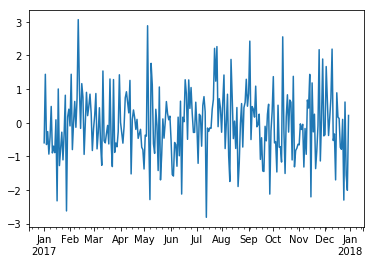

In [34]:
index_ouverture= pd.bdate_range('2017-01-01','2017-12-31')
data=np.random.randn(index_ouverture.size)
pd.Series(data, index=index_ouverture).plot()

On peut aussi utiliser date_range() avec différents paramètres. Si par exemple,
on désire générer un index avec des relevés toutes les 2 heures entre le 1er février
2018 à 8h00 et le 31 mars 2018 à 8h00, on utilisera :

In [35]:
index_temps = pd.date_range('2018-02-01 08:00:00','2018-03-31 08:00:00', freq='2h')
print(index_temps.shape, index_temps.dtype)

(697,) datetime64[ns]


De nombreuses possibilités sont accessibles pour le traitement des dates et des heures. 

Ainsi, si plutôt que des dates et des heures, vous préférez utiliser des périodes (ceci revient à utiliser un mois plutôt que le premier jour du mois comme valeur de votre index), vous pouvez le faire avec la fonction period_range().

In [36]:
pd.period_range("01-01-2017","01-01-2018", freq="M")

PeriodIndex(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01'],
            dtype='period[M]', freq='M')

On a ainsi généré une suite de mois. Ceci peut se faire sur des semaines (W), des trimestres (Q), des années (A)…

Si on désire générer des périodes, on pourra le faire grâce à pd.period() :

In [37]:
pd.period_range(pd.Period("2017-01", freq="M"), pd.Period("2019-01", freq="M"), freq="Q")

PeriodIndex(['2017Q1', '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2',
             '2018Q3', '2018Q4', '2019Q1'],
            dtype='period[Q-DEC]', freq='Q-DEC')

Par ailleurs, vous pouvez traiter les fuseaux horaires de manière simplifiée avec
Pandas en utilisant la propriété .tz. Par défaut, une date n’est associée à aucune
timezone :

In [38]:
index_temps.tz is None

True

Pour définir un fuseau horaire, on le fait généralement dans la fonction date_range(), qui a un paramètre tz = . Les fuseaux horaires peuvent être définis, avec
une chaîne de caractères incluant une combinaison zone/ville ("Europe/Paris"), vous pouvez en obtenir la liste exhaustive en important :

In [39]:
from pytz import common_timezones, all_timezones
all_timezones[:10]

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau']

Si vous avez déjà défini vos dates et que vous désirez leur ajouter un fuseau horaire, vous allez utiliser la méthode tz_localize(). Imaginons que l’on génère
des données toutes les deux heures à Paris, on veut transformer cet index en passant sur le fuseau horaire de Nouméa en Nouvelle-Calédonie, voici le code :

In [40]:
index_heures=pd.date_range("2018-01-01 09:00:00", "2018-01-01 18:00:00", freq="2h")
index_heures_paris = index_heures.tz_localize("Europe/Paris")
index_heures_paris

DatetimeIndex(['2018-01-01 09:00:00+01:00', '2018-01-01 11:00:00+01:00',
               '2018-01-01 13:00:00+01:00', '2018-01-01 15:00:00+01:00',
               '2018-01-01 17:00:00+01:00'],
              dtype='datetime64[ns, Europe/Paris]', freq='2H')

In [41]:
index_heures_noumea = index_heures_paris.tz_convert("Pacific/Noumea")
index_heures_noumea

DatetimeIndex(['2018-01-01 19:00:00+11:00', '2018-01-01 21:00:00+11:00',
               '2018-01-01 23:00:00+11:00', '2018-01-02 01:00:00+11:00',
               '2018-01-02 03:00:00+11:00'],
              dtype='datetime64[ns, Pacific/Noumea]', freq='2H')

Il existe de nombreux autres outils pour travailler sur les dates en Python.
Notamment, lorsqu’on traite des séries temporelles, on peut utiliser l’outil rolling :

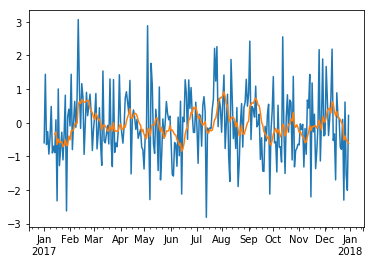

In [42]:
pd.Series(data, index=index_ouverture).plot()
pd.Series(data, index=index_ouverture).rolling(window=10).mean().plot()
#La deuxième ligne permet d’afficher la moyenne prise sur 10 points adjacents.

### 4.3.8 Le traitement des données manquantes
Les données manquantes sont un domaine de la data science à part entière. Leur traitement nécessite une réflexion bien au-delà de quelques lignes de codes.

Dans tous vos projets data science, vous serez confronté à des données manquantes, elles sont réparties en trois types principaux :

- Les données manquantes complètement aléatoirement
- Les données manquantes aléatoirement
- Les données manquantes non aléatoirement

Ainsi, pour les deux premiers cas, on pourra penser à des méthodes d’imputation
alors que pour le troisième il ne sera pas possible de faire cela.

#### Les données manquantes en Python
NumPy possède un code standard pour gérer les données manquantes, il s’agit
de NaN. On peut définir un élément d’un array comme une donnée manquante en
utilisant :

In [43]:
table = np.random.rand(5000, 10)
table[0,1]=np.nan
table[0,1]

nan

L’avantage d’utiliser ce codage réside dans le fait que les nan n’altèrent pas le type
de votre array et qu’ils ne sont pas pris en compte dans les calculs de statistiques
descriptives avec les fonctions adaptées :

In [44]:
vec=np.ones(10)
vec[3]=np.nan
np.nansum(vec)

9.0

Lorsque vous importez des données avec Pandas, celui-ci va automatiquement
remplacer les données manquantes par des codes nan.

#### La suppression des données manquantes
L’approche la plus simple pour traiter des données manquantes est de supprimer les observations comportant des données manquantes.

Pandas comporte de nombreuses méthodes pour cela. Si nous prenons les données sur les salaires des employés de la ville de Boston, nous pouvons utiliser :

In [45]:
# la table globale
boston.shape

(22245, 12)

In [46]:
# la table lorsqu’on retire les lignes avec données manquantes
boston.dropna().shape

(123, 12)

In [47]:
# la table lorsqu’on retire les colonnes avec des données manquantes
boston.dropna(axis = 1).shape

(22245, 4)

On voit que dans cette table de nombreuses données manquantes existent surtout sur huit colonnes. Quatre colonnes sont complètes.

#### La complétion par la moyenne, le mode ou la médiane

Avant de compléter nos données, il va falloir transformer nos données Boston de manière à avoir des données numériques. En s’inspirant du code vu plus haut pour les données AirBnB, nous pouvons faire cela avec :

In [48]:
for col in boston.columns :
    if boston[col].dtype==object :
        boston[col]=pd.to_numeric(boston[col].str.replace(r"\(.*\)","")\
                                  .str.replace(",","").str.strip("$"),
                                  errors='ignore')

Dans ce code, on supprime d’abord les parenthèses en utilisant une expression régulière (voir le chapitre 2), puis on élimine les virgules et on enlève du sigle $ lorsqu’il est en début de chaîne.

On a maintenant huit colonnes en float avec des salaires.

On peut maintenant travailler sur les données manquantes. Il existe deux moyens de compléter par la moyenne ou par la médiane.

Un premier en utilisant Pandas :

In [49]:
# pour la moyenne
for col in boston.columns :
    if boston[col].dtype ==np.number :
        boston[col]= boston[col].fillna(boston[col].mean())

        
# pour la médiane
for col in boston.columns :
    if boston[col].dtype ==np.number :
        boston[col]= boston[col].fillna(boston[col].median())

# pour le mode, on utilise une condition à l’intérieur de l’appel de la boucle 
# qui est équivalente à ce que nous faisions plus haut
# le calcul du mode renvoie un objet Series et non une valeur comme les autres 
# méthodes, d’où le [0]
for col in boston.select_dtypes(object).columns :
    boston[col]= boston[col].fillna(boston[col].mode()[0])

Le package Scikit-Learn permet aussi de faire des remplacements par la moyenne
ou la médiane :

In [50]:
# on importe la classe depuis le module preprocessing (jusqu'à sklearn 0.22)
from sklearn.preprocessing import Imputer
# on crée un objet de cette classe avec la stratégie d’imputation comme
# paramètre
imputer = Imputer(strategy = "mean")
# on construit un nouveau jeu de données en appliquant la méthode
# .fit_transform()
boston_imputee = imputer.fit_transform(boston.select_dtypes(np.number))

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [51]:
# à partir de sklearn version 0.20
from sklearn.impute import SimpleImputer
# on crée un objet de cette classe avec la stratégie d’imputation comme
# paramètre
imputer = SimpleImputer(strategy = "mean")
# on construit un nouveau jeu de données en appliquant la méthode
# .fit_transform()
boston_imputee2 = imputer.fit_transform(boston.select_dtypes(np.number))

### 4.3.9 Le traitement des colonnes avec des données qualitatives
Les données qualitatives sont extrêmement présentes dans les données. Dès que vous travaillez sur des données socio-démographiques sur des individus, vous allez rencontrer des données qualitatives. Le traitement des données qualitatives est souvent négligé dans les ouvrages de traitement de la donnée. Il est donc primordial de bien expliquer le traitement qu’elles requièrent.

#### Le type categorical
Les données qualitatives sont des valeurs textuelles par défaut. Pandas propose un type spécifique pour traiter ce type de données. Le type categorical permet d’optimiser le traitement de ce type de données.

Il permet de créer et de transformer des données de ce type. Vous avez importé des données avec des variables qualitatives, Pandas va automatiquement les considérer comme du type object. Vous pourrez le voir en utilisant la propriété .dtype.
Si vous désirez transformer ce type en un type categorical, vous pouvez utiliser la fonction pd.Categorical() :

In [52]:
var_quali=pd.Categorical(["Boston","Paris","Londres","Paris", "Boston"])
var_quali

[Boston, Paris, Londres, Paris, Boston]
Categories (3, object): [Boston, Londres, Paris]

In [53]:
# on peut ajouter une modalité
var_quali=var_quali.add_categories("Rome")
# on alloue cette valeur à un élément de notre objet
var_quali[4]="Rome" 

Si on modifie notre objet en y ajoutant une modalité non définie au préalable alors on aura un message d’erreur.
Si on veut transformer une colonne objet en category, on utilise :

In [54]:
boston["POSTAL"]=boston["POSTAL"].astype("category", ordered=False)
#équivalent sans warning
boston["POSTAL"]=boston["POSTAL"].astype(pd.api.types.CategoricalDtype(ordered=False))

boston["POSTAL"].dtype


C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


CategoricalDtype(categories=['10025', '10033', '10128', '1027', '1028', '1040', '10466',
                  '10512', '1057', '1085',
                  ...
                  '95008', '97201', '97209', '97410', '98074', '98121',
                  '98144', '98296', 'B1S 3', 'UNKNO'],
                 ordered=False)

On utilise ordered = False car il n’y a pas d’ordre entre les modalités de notre colonne. Si une notion d’ordre doit être ajoutée, on ajoute la liste des modalités et on
passe le paramètre ordered à True.

Le type Categorical est inspiré du type factor de R.

#### La transformation des données
Pour traiter des données qualitatives, il faudra les transformer. 

En effet, les algorithmes que vous aurez à utiliser sont basés sur des données numériques et donc des variables quantitatives.

Si vous travaillez sur des données nominales, il va falloir transformer les variables en indicatrices. C’est-à-dire que vous allez obtenir une colonne pour chaque modalité de votre variable qualitative.

Cette approche peut être appliquée avec deux packages que nous utilisons souvent : Pandas et Scikit-Learn.

Dans le cadre de nos données sur les logements AirBnB, nous avons plusieurs variables qualitatives, notamment roomtype qui a trois modalités :

In [55]:
listing["room_type"].value_counts()

Entire home/apt    4329
Private room        623
Shared room          48
Name: room_type, dtype: int64

##### Approche Pandas avec get_dummies() :

In [56]:
frame_room_type = pd.get_dummies(listing["room_type"])
frame_room_type.head()

,Entire home/apt,Private room,Shared room
52948,1,0,0
11523,1,0,0
57517,1,0,0
55551,0,1,0
2440,1,0,0


Cette fonction crée un nouveau DataFrame 

##### Approche Scikit-Learn avec OneHotEncoder() :

Dans ce cas, il faut que la variable qualitative soit déjà sous forme d’entiers entre 0 et p-1, p étant le nombre de modalités de notre variable.

On va combiner deux classes de Scikit-Learn : LabelEncoder et OneHotEncoder.

La première va permettre de recoder les valeurs textuelles en entiers et la seconde de construire des colonnes binaires à partir des valeurs de la variable transformée.

Voici le code :

In [57]:
# on importe les classes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# on crée un objet de la classe LabelEncoder
encode1=LabelEncoder()
# on crée un objet de la classe OneHotEncoder
encode2=OneHotEncoder(sparse = False)
# on combine l’application des deux classes
array_out=encode2.fit_transform(encode1.fit_transform(listing["room_type"]).reshape(-1,1))
# on transforme la sortie en DataFrame
pd.DataFrame(array_out, columns=listing["room_type"].unique()).head()

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,Entire home/apt,Private room,Shared room
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0


**Attention à partir de la version 0.20 de Scikit Learn, OneHotEncoder peut gérer des données non numériques, on a alors :**

In [58]:
# on importe les classes
from sklearn.preprocessing import OneHotEncoder
# on crée un objet de la classe OneHotEncoder
encode=OneHotEncoder(sparse = False)
# on l'applique directement sur la colonnes initiale
array_out=encode.fit_transform(np.array(listing["room_type"]).reshape(-1,1))
# on transforme la sortie en DataFrame
pd.DataFrame(array_out, columns=listing["room_type"].unique()).head()

,Entire home/apt,Private room,Shared room
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0


Si vous travaillez sur des données ordinales (avec des modalités ordonnées), il vous suffit de recoder une variable avec des valeurs chiffrées (attention, cette approche
n’est valable que pour des données ordinales).

##### Approche avec Pandas :

Il n’y a pas d’approche automatisée, on peut utiliser le code suivant :

In [59]:
listing["room_type2"]=listing["room_type"].map(dict(zip(listing["room_type"]\
                                                        .unique(),
                                                        range(listing["room_type"].nunique())) ))

On crée donc une colonne en utilisant un dictionnaire qui permet de faire correspondre
des éléments de celui-ci à des valeurs entières.

##### Approche avec Scikit-Learn :

Cette approche est plus simple, elle se base sur l’outil LabelEncoder et se fait avec
ce code :

In [60]:
from sklearn.preprocessing import LabelEncoder
encode1=LabelEncoder()
listing["room_type2"]=encode1.fit_transform(listing["room_type"])

Ces méthodes sont centrales car la plupart des algorithmes en Python ne
supportent pas le type categorical.

### 4.3.10 Les transformations numériques

Lorsque vous travaillez sur des données, un certain nombre de transformations de base sont nécessaires. Trois packages pourront être utiles pour ce type de transformations : Scikit-Learn, Pandas et SciPy.

Avec Pandas, la plupart des transformations se font en faisant les calculs directement en utilisant les fonctions universelles de Pandas.

Avec Scikit-Learn, l’approche est légèrement différente. Dans ce cas, on utilise des classes permettant de transformer les données.

SciPy nous permet d’appliquer des transformations plus spécifiques.

Nous utiliserons les données sur les employés de la ville de Boston desquelles nous extrayons les colonnes numériques :

In [61]:
boston_num=boston.select_dtypes(include=[np.number])

#### Centrer et réduire les données

In [62]:
# avec Pandas pour centrer et réduire
boston_std=boston_num.apply(lambda x : (x-x.mean())/x.std())
boston_std.head()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
0,1.850181,8.933771e-13,1.441325,-0.745999,1.373371e-12,1.274160e-12,6.881953e+00,2.036972
1,-0.123227,8.933771e-13,-0.041237,-1.393149,1.373371e-12,1.274160e-12,-1.452477e-12,-0.184888
2,1.701400,8.933771e-13,0.375293,1.301949,1.373371e-12,4.318385e-01,6.015775e+00,2.614268
3,0.910494,1.820365e+00,1.426269,6.827857,-3.098121e+00,-4.137334e-01,3.238995e+00,3.203649
4,0.232093,8.933771e-13,-0.524861,-0.764557,1.373371e-12,1.274160e-12,-1.452477e-12,0.131807


In [63]:
# avec Scikit-Learn, on utilisera la classe StandardScaler :
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=True, with_std=True)
rescaled=scaler.fit_transform(boston_num)
pd.DataFrame(rescaled, index=boston_num.index, columns=boston_num.columns).head()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
0,1.850223,-2.926772e-15,1.441358,-0.746016,-5.098004e-16,0.000000,6.882107,2.037018
1,-0.123229,-2.926772e-15,-0.041238,-1.393180,-5.098004e-16,0.000000,0.000000,-0.184892
2,1.701439,-2.926772e-15,0.375301,1.301979,-5.098004e-16,0.431848,6.015910,2.614326
3,0.910515,1.820406e+00,1.426301,6.828010,-3.098191e+00,-0.413743,3.239068,3.203721
4,0.232098,-2.926772e-15,-0.524873,-0.764574,-5.098004e-16,0.000000,0.000000,0.131810


#### Changer d’échelle

On utilise pour passer à une échelle 0-100 :

In [64]:
# avec Pandas
boston_0_100=boston_num.apply(lambda x : (x-x.min())/(x.max()-x.min())*100)
boston_0_100.head()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
0,48.942225,9.489153,7.311559,5.625871,7.765386,14.726334,63.678644,47.964260
1,21.507463,9.489153,1.919201,1.068627,7.765386,14.726334,42.266215,16.945978
2,46.873844,9.489153,3.434198,20.047572,7.765386,17.086743,60.983628,56.023593
3,35.878487,17.385912,7.256796,58.961144,0.020329,12.464888,52.343987,64.251647
4,26.447199,9.489153,0.160171,5.495185,7.765386,14.726334,42.266215,21.367201


In [65]:
# avec Scikit-Learn
from sklearn.preprocessing import MinMaxScaler
minmaxscaler=MinMaxScaler((0,100))
boston_0_100=minmaxscaler.fit_transform(boston_num)
boston_0_100=pd.DataFrame(boston_0_100, index=boston_num.index, columns=boston_num.columns)
boston_0_100.head()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
0,48.942225,9.489153,7.311559,5.625871,7.765386,14.726334,63.678644,47.964260
1,21.507463,9.489153,1.919201,1.068627,7.765386,14.726334,42.266215,16.945978
2,46.873844,9.489153,3.434198,20.047572,7.765386,17.086743,60.983628,56.023593
3,35.878487,17.385912,7.256796,58.961144,0.020329,12.464888,52.343987,64.251647
4,26.447199,9.489153,0.160171,5.495185,7.765386,14.726334,42.266215,21.367201


#### Transformation de Box-Cox
Lorsque vous désirez obtenir des données suivant une loi normale, vous risquez d’avoir besoin d’une transformation qui permette de se rapprocher de cette loi.

La transformation de Box-Cox est une transformation qui peut gérer ce problème.

Elle ne s’applique qu’à des données positives. Celle-ci est disponible dans le package SciPy et s’utilise de la manière suivante :

In [66]:
from scipy import stats
total_earning_trans=stats.boxcox(boston_num["TOTAL EARNINGS"])

### 4.3.11 Echantillonnage des données

Nous allons présenter deux approches d’échantillonnage :

- l'échantillonnage aléatoire sans remise,
- l'échantillonnage stratifié.

Pandas propose une méthode d’échantillonnage simple à mettre en oeuvre, il s’agit de la méthode sample.
Si on désire échantillonner aléatoirement 1000 lignes de notre base Boston, on utilisera :

In [67]:
boston_aleat_1000=boston.sample(n=1000)
boston_aleat_1000.shape

(1000, 12)

On peut se servir du paramètre frac = si on désire obtenir un échantillon de la taille d’une fraction du jeu de données initial.

L’échantillonnage stratifié consiste à reproduire dans vos échantillons les mêmes répartitions de certaines variables que dans l’échantillon initial.

Il peut se faire avec Pandas ou avec Scikit-Learn. On utilisera dans ce cas le listing des logements disponibles à Paris. 

Si nous voulons échantillonner 10 % des logements en conservant la répartition du type de chambre (room_type), on utilisera :

In [68]:
# répartition dans l’échantillon initial
listing["room_type"].value_counts(normalize=True)

Entire home/apt    0.8658
Private room       0.1246
Shared room        0.0096
Name: room_type, dtype: float64

In [69]:
# échantillonnage stratifié
listing_sample=listing.groupby('room_type').apply(lambda x : x.sample(frac=.1))
# repartition dans l’échantillon final
listing_sample["room_type"].value_counts(normalize=True)

Entire home/apt    0.866
Private room       0.124
Shared room        0.010
Name: room_type, dtype: float64

### 4.3.12 La construction de tableaux croisés

Les tableaux croisés peuvent être très utiles pour visualiser des croisements de colonnes de variables qualitatives et les intégrer dans d’autres calculs.
Deux fonctions dans Pandas sont utiles : la méthode frame.pivot_table() et la fonction pd.crosstab().

La seule différence entre ces deux approches réside dans les données qui sont acceptées dans chaque fonction. Pour pivot_table, sachant que c’est une méthode
appliquée à un DataFrame, toutes les données doivent venir de ce DataFrame. La fonction crosstab est différente, elle peut prendre en entrée des données issues
de plusieurs DataFrame ou d’arrays.

Si nous reprenons nos données AirBnB et que nous désirons croiser deux colonnes,
nous allons utiliser :

In [70]:
pd.crosstab(listing['instant_bookable'], listing['room_type'])

room_type,Entire home/apt,Private room,Shared room
instant_bookable,,,
f,3171,467,33
t,1158,156,15


Par défaut, cet outil inclut des comptages dans le tableau. Mais si on désirait afficher la moyenne du prix des logements, on utiliserait :

In [71]:
pd.crosstab(listing['instant_bookable'], listing['room_type'],
            values=listing['price'],
            aggfunc="mean")

room_type,Entire home/apt,Private room,Shared room
instant_bookable,,,
f,101.094292,68.184154,40.878788
t,107.669257,68.467949,36.866667


In [72]:
listing.pivot_table(values='price', 
                    index='instant_bookable', 
                    columns='room_type',
                    aggfunc='mean')

room_type,Entire home/apt,Private room,Shared room
instant_bookable,,,
f,101.094292,68.184154,40.878788
t,107.669257,68.467949,36.866667


On peut aller plus loin en combinant plusieurs variables et en combinant plusieurs statistiques dans le tableau :

In [73]:
listing.pivot_table(values='price',
                    index=['is_business_travel_ready','instant_bookable'],
                    columns='room_type', 
                    aggfunc=['mean','count'])

mean               \
room_type                                 Entire home/apt Private room   
is_business_travel_ready instant_bookable                                
f                        f                     100.346267    68.184154   
                         t                     105.421632    68.467949   
t                        f                     123.153846          NaN   
                         t                     144.268657          NaN   

                                                                count  \
room_type                                 Shared room Entire home/apt   
is_business_travel_ready instant_bookable                               
f                        f                  40.878788          3067.0   
                         t                  36.866667          1091.0   
t                        f                        NaN           104.0   
                         t                        NaN            67.0   

                                                                    
room_type                                 Private room Shared room  
is_business_travel_ready instant_bookable                           
f                        f                       467.0        33.0  
                         t                       156.0        15.0  
t                        f                         NaN         NaN  
                         t                         NaN         NaN

## 4.4 Extraire des statistiques descriptives

### 4.4.1 Statistiques pour données quantitatives

Lorsqu'on calcule des statistiques descriptives spécifiques aux données quantitatives sur un DataFrame complet, Pandas n’affiche des résultats que pour les variables quantitatives (sans message d’erreur pour les colonnes non quantitatives).

Statistiques descriptives de base
Quelques méthodes statistiques universelles de Pandas :

In [74]:
# moyenne
boston.mean()

REGULAR                      61455.764284
RETRO                         2722.555034
OTHER                         3875.576450
OVERTIME                     15761.125615
INJURED                      22166.982634
DETAIL                       19292.675939
QUINN/EDUCATION INCENTIVE    16133.739261
TOTAL EARNINGS               71517.447431
dtype: float64

In [75]:
# variance
boston.var()

REGULAR                      1.353779e+09
RETRO                        1.545119e+06
OTHER                        4.640917e+07
OVERTIME                     1.040817e+08
INJURED                      5.092599e+07
DETAIL                       5.127755e+07
QUINN/EDUCATION INCENTIVE    1.403539e+06
TOTAL EARNINGS               2.614014e+09
dtype: float64

In [76]:
# écart-type
boston.std()

REGULAR                      36793.733234
RETRO                         1243.028295
OTHER                         6812.427267
OVERTIME                     10202.043674
INJURED                       7136.245092
DETAIL                        7160.834192
QUINN/EDUCATION INCENTIVE     1184.710373
TOTAL EARNINGS               51127.428966
dtype: float64

In [77]:
# médiane
boston.median()

REGULAR                      61455.764284
RETRO                         2722.555034
OTHER                         3875.576450
OVERTIME                     15761.125615
INJURED                      22166.982634
DETAIL                       19292.675939
QUINN/EDUCATION INCENTIVE    16133.739261
TOTAL EARNINGS               66218.240000
dtype: float64

In [78]:
# matrice de corrélation
boston.corr()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
REGULAR,1.000000,0.151931,-0.003753,0.213226,-0.088766,0.013835,0.109378,0.868466
RETRO,0.151931,1.000000,0.053184,0.401342,-0.033370,0.039013,0.016559,0.293904
OTHER,-0.003753,0.053184,1.000000,0.097863,0.070013,0.024574,0.016010,0.126975
OVERTIME,0.213226,0.401342,0.097863,1.000000,-0.043067,0.080187,0.159767,0.454531
INJURED,-0.088766,-0.033370,0.070013,-0.043067,1.000000,-0.006834,0.019239,0.007562
DETAIL,0.013835,0.039013,0.024574,0.080187,-0.006834,1.000000,0.038830,0.178945
QUINN/EDUCATION INCENTIVE,0.109378,0.016559,0.016010,0.159767,0.019239,0.038830,1.000000,0.137591
TOTAL EARNINGS,0.868466,0.293904,0.126975,0.454531,0.007562,0.178945,0.137591,1.000000


Une autre fonction intéressante est la méthode .describe() qui affiche un certain nombre de statistiques pour les variables quantitatives (elle ne fait que cela par défaut mais nous verrons plus loin qu’elle peut s’appliquer aux variables qualitatives).

In [79]:
boston.describe()

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
count,22245.000000,22245.000000,22245.000000,22245.000000,22245.000000,22245.000000,22245.000000,22245.000000
mean,61455.764284,2722.555034,3875.576450,15761.125615,22166.982634,19292.675939,16133.739261,71517.447431
std,36793.733234,1243.028295,6812.427267,10202.043674,7136.245092,7160.834192,1184.710373,51127.428966
min,0.000000,3.500000,0.000000,0.000000,0.000000,0.000000,40.210000,3.500000
25%,30823.270000,2722.555034,850.000000,15761.125615,22166.982634,19292.675939,16133.739261,30160.550000
50%,61455.764284,2722.555034,3875.576450,15761.125615,22166.982634,19292.675939,16133.739261,66218.240000
75%,92969.550000,2722.555034,3875.576450,15761.125615,22166.982634,19292.675939,16133.739261,102602.380000
max,264660.690000,28657.850000,187299.320000,144873.750000,285458.880000,131008.000000,38116.790000,366232.650000


Si vous voulez construire votre propre DataFrame de statistiques, vous pouvez utiliser la méthode .agg(). Par exemple :

In [80]:
boston.agg(["mean","std"])

,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS
mean,61455.764284,2722.555034,3875.576450,15761.125615,22166.982634,19292.675939,16133.739261,71517.447431
std,36793.733234,1243.028295,6812.427267,10202.043674,7136.245092,7160.834192,1184.710373,51127.428966


#### Des statistiques plus avancées
Il peut arriver que des statistiques plus avancées soient nécessaires, notamment en se basant sur des distributions de probabilités. Pour cela, on utilisera plutôt le
package SciPy et plus précisément scipy.stats qui possède de nombreuses statistiques importantes.

Par exemple, on peut calculer l’asymétrie d’une distribution (skewness) en utilisant :

In [81]:
from scipy.stats import skew
skew(listing["price"])

9.948874039832083

### 4.4.2 Statistiques pour données qualitatives
Les statistiques descriptives pour des variables qualitatives sont très différentes de celles pour des variables quantitatives. Ainsi, on s’intéresse généralement au mode et à la fréquence des modalités de la variable, Pour cela, on pourra obtenir des statistiques simples en utilisant la méthode *.describe(include = "all")*.

D’autres approches sont possibles mais elles s’appliqueront variables par variables sur un objet Series. Ainsi, on peut utiliser :

In [82]:
# nombre de modalités
listing["room_type"].nunique()

3

In [83]:
# liste des modalités
listing["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [84]:
# liste et fréquence d’apparition des modalités
listing["room_type"].value_counts()

Entire home/apt    4329
Private room        623
Shared room          48
Name: room_type, dtype: int64

In [85]:
# calcul du mode
listing["room_type"].mode()

0    Entire home/apt
dtype: object

Ces méthodes vont compter le nombre de modalité, afficher toutes les modalités, afficher les modalités ordonnées par fréquence d’apparition avec la fréquence associée,et enfin afficher le mode (la modalité avec la fréquence la plus élevée).

La méthode .value_counts() possède un certain nombre de paramètres pour inclure les données manquantes, normaliser les résultats...

## 4.5 Utilisation du groupby pour décrire des données

### 4.5.1 Le principe

La méthode .groupby est une méthode qui permet de construire un objet à partir d’un DataFrame. Cet objet sépare les données en fonction des modalités d’une ou de plusieurs variables qualitatives. On obtiendra ainsi de manière quasi-immédiate des
indicateurs par modalités. 

De nombreuses méthodes sont disponibles sur ces objets groupby afin de maximiser la simplicité de manipulation de données.
Généralement, on suppose que le groupby est basé sur trois étapes : séparation/application et combinaison.

Par exemple, sur les données AirBnB, on peut faire cela par type de chambres :

In [86]:
listing_group_room = listing.groupby("room_type")
listing_group_room["price"].mean()

room_type
Entire home/apt    102.853084
Private room        68.255217
Shared room         39.625000
Name: price, dtype: float64

On sépare et on calcule la moyenne, et on rassemble les résultats dans un nouvel objet. On affiche donc dans un objet Series les prix moyens par type de chambre. On voit ici qu’on a utilisé la méthode .mean() de la classe des objets groupby.

### 4.5.2 Les opérations sur les objets groupby
On peut très simplement obtenir des statistiques plus poussées avec des groupby.

De nombreuses méthodes de transformation de données pourront être appliquées avec une étape .groupby().

### 4.5.3 Apply : une méthode importante pour manipuler vos groupby

La méthode apply permet d’appliquer n’importe quelle fonction sur vos données.

Si par exemple, vous désirez calculer l’écart salarial au sein de chaque département sur les données des salariés de la ville de Boston, vous allez devoir utiliser la différence entre le maximum et le minimum. Il n’existe pas de fonction universelle. 

Nous allons donc utiliser un groupby et la méthode apply :

In [87]:
diff_salaires_dep = boston.groupby('DEPARTMENT NAME')['TOTAL EARNINGS']\
                        .apply(lambda x : x.max()-x.min())
diff_salaires_dep.sort_values(ascending = False).head()

DEPARTMENT NAME
Boston Police Department    366229.15
BPS Business Service        284561.66
Boston Fire Department      276546.71
Superintendent              243562.93
Kilmer K-8                  228972.45
Name: TOTAL EARNINGS, dtype: float64

### 4.5.4 Cas concret d’utilisation d’un groupby

Nous travaillons sur les données AirBnB. Nous désirons obtenir des statistiques descriptives sur les prix et leurs variations au sein de chaque arrondissement de Paris. Pour cela nous allons utiliser un groupby :

In [88]:
# on nettoie les données de code postaux
listing["zip_clean"]=listing.zipcode.str.extract('(^\d*)')
# on ne garde que les code de 5 valeurs commençant par 75 et on extrait le numéro de l’arrondissement
listing["zip_clean2"]=np.where((listing["zip_clean"].str[: 2]=="75")&(listing["zip_clean"].str.len()==5),
                               listing["zip_clean"].str[-2 :], np.nan)
# on construit des statistiques par arrondissement
listing.groupby("zip_clean2")["price"].agg(["mean","std"])

,mean,std
zip_clean2,,
01,140.080808,86.504179
02,120.818792,74.224099
03,134.375566,155.931130
04,123.898810,76.812911
05,102.918129,72.464955
06,142.091603,124.404270
07,159.314685,150.858269
08,172.380531,143.977014
09,100.913420,80.027937


Si nous désirons étudier les variations par arrondissement et par type d’appartement, nous pourrons avoir deux clés pour notre groupby :

In [89]:
listing.groupby(["zip_clean2","room_type"])["price"].mean()

zip_clean2  room_type      
01          Entire home/apt    140.428571
            Private room       145.833333
            Shared room        107.333333
02          Entire home/apt    125.123077
            Private room        96.588235
            Shared room         47.000000
03          Entire home/apt    139.360577
            Private room        57.000000
            Shared room         26.000000
04          Entire home/apt    125.371795
            Private room       112.000000
            Shared room         25.000000
05          Entire home/apt    103.551948
            Private room        97.176471
06          Entire home/apt    146.040323
            Private room        72.142857
07          Entire home/apt    164.254098
            Private room       135.250000
            Shared room         38.000000
08          Entire home/apt    180.774510
            Private room        94.545455
09          Entire home/apt    103.141414
            Private room        88.625000
      

De nombreuses autres applications sont disponibles avec le groupby.